In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)

### Load dataset

Each Image size = 300X300 pixels


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/horse-or-human',
    labels = 'inferred',
    label_mode = 'binary',
    image_size=(300,300),
    #batch_size = 20,
    #validation_split=0.2, ###If `subset` is set, `validation_split` must be set, and inversely
    #subset = 'training', ###If `subset` is set, `validation_split` must be set, and inversely
    #shuffle=False,  ###To get same results
    seed = 22
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/validation-horse-or-human',
    labels = 'inferred',
    label_mode = 'binary',
    image_size=(300,300),
    #batch_size = 20,
    #validation_split=0.2, ###If `subset` is set, `validation_split` must be set, and inversely
    #subset = 'validation', ###If `subset` is set, `validation_split` must be set, and inversely
    #shuffle=False, ###To get same results
    seed = 22
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/rv-test-horse-or-human/',
    image_size=(300,300),
    label_mode=None, #Does not return label
    shuffle=False,
    seed = 22
)
print(train_ds,val_ds,test_ds)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.
Found 4 files belonging to 1 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))> <BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))> <BatchDataset element_spec=TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None)>


2022-11-12 23:12:32.897808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### EDA

Horse = 0, Human = 1

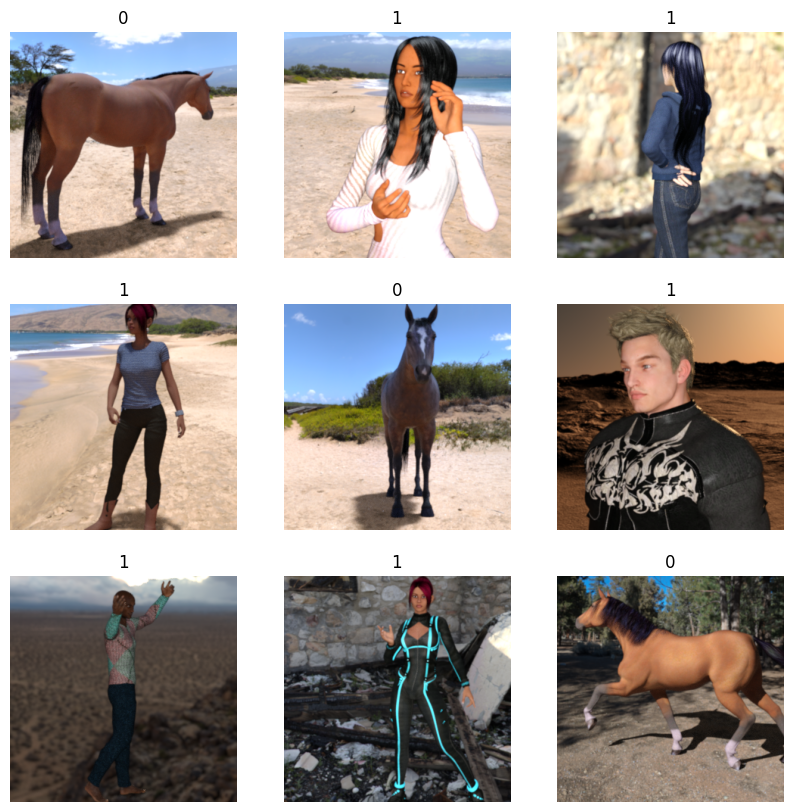

In [11]:
##### Training Set or/and Validation Set

#i = 0
#for x,y in val_ds:
#    i += 1
#    print("Batch ",i)
#    #print("####### X (",i,") = ",x.shape,type(x))
#    #print("####### Y (",i,") = ",y.shape,type(y))

#print("Last batch (",i,") = ",x.shape,type(x))
#plt.imshow(x.numpy()[0].astype('uint8'))  #Float values
#plt.show()

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Feature scaling (Normalization) => Preprocessing layer

In [12]:
train_rescale_augment = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest'), #360 degrees = 100% => 90 deg = 25% (0.25), 45 deg = 0.125
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
    #tf.keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(height_factor=0.2,fill_mode='nearest'),
    tf.keras.layers.RandomFlip(mode='horizontal')
])
train_ds = train_ds.map(lambda x,y : (train_rescale_augment(x),y))

val_test_rescale = tf.keras.layers.Rescaling(scale=1./255)
val_ds = val_ds.map(lambda x,y : (val_test_rescale(x),y))
test_ds_scaled = test_ds.map(lambda x : val_test_rescale(x))

### Build MODEL

In [13]:
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,verbose=1)
callback_cp = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'Models/C1W4HorsesHumans/Checkpoint/hh_model', #_{epoch}',
    monitor = 'val_accuracy',save_best_only = True,save_weights_only = True,verbose=1)
#class AccCheck(tf.keras.callbacks.Callback):
#    def on_epoch_end(self, epoch, logs=None):
#        if logs['accuracy'] >= 0.99:
#            print("Reached 99% accuracy so cancelling training!")
#            self.model.stop_training = True

hh_model = tf.keras.models.Sequential([
    #rescale_layer,
    tf.keras.layers.Conv2D(filters=16,kernel_size=3,activation='relu',input_shape=(300,300,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    #tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
    #tf.keras.layers.MaxPool2D(),
    #tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
    #tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [14]:
hh_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 35, 35, 64)      

In [15]:
hh_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [16]:
hh_model_hist = hh_model.fit(train_ds,
             validation_data = val_ds,
             epochs = 15,
             callbacks = [callback_cp,callback_es])

Epoch 1/15
33/33 [==============================] - ETA: 0s - loss: 1.7585 - accuracy: 0.6319
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to Models/C1W4HorsesHumans/Checkpoint/hh_model
33/33 [==============================] - 93s 3s/step - loss: 1.7585 - accuracy: 0.6319 - val_loss: 2.1296 - val_accuracy: 0.5000
Epoch 2/15
33/33 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.7410
Epoch 2: val_accuracy improved from 0.50000 to 0.60547, saving model to Models/C1W4HorsesHumans/Checkpoint/hh_model
33/33 [==============================] - 101s 3s/step - loss: 0.6364 - accuracy: 0.7410 - val_loss: 2.9611 - val_accuracy: 0.6055
Epoch 3/15
33/33 [==============================] - ETA: 0s - loss: 0.6314 - accuracy: 0.7634
Epoch 3: val_accuracy did not improve from 0.60547
33/33 [==============================] - 84s 3s/step - loss: 0.6314 - accuracy: 0.7634 - val_loss: 1.2044 - val_accuracy: 0.5938
Epoch 4/15
33/33 [==============================] 

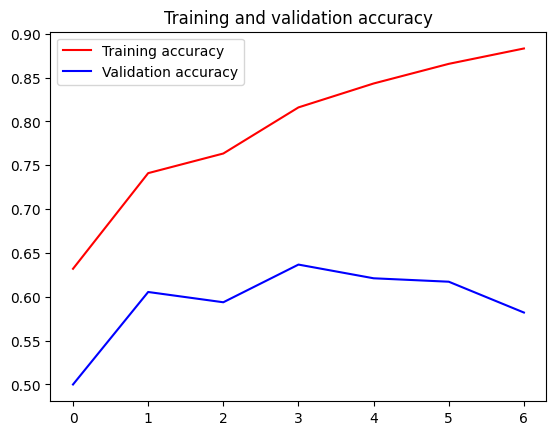

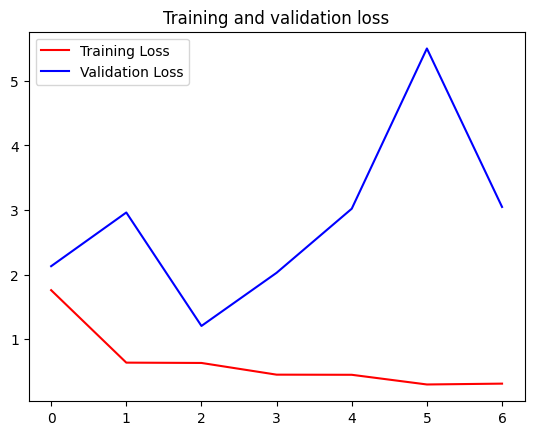

In [17]:
# Plot the model results
acc = hh_model_hist.history['accuracy']
val_acc = hh_model_hist.history['val_accuracy']
loss = hh_model_hist.history['loss']
val_loss = hh_model_hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
# Save the model, and reload it

hh_model.save('Models/C1W4HorsesHumans/C1W4_ImageClassification_HorsesHumans_model.h5')
new_hh_model = tf.keras.models.load_model('Models/C1W4HorsesHumans/C1W4_ImageClassification_HorsesHumans_model.h5')
new_hh_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 35, 35, 64)      

### Predict

Horse = 0, Human = 1

1/1 [==============================] - 0s 409ms/step
[[1.       ]
 [0.9807919]
 [0.0814596]
 [1.       ]]
(4, 300, 300, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
Human


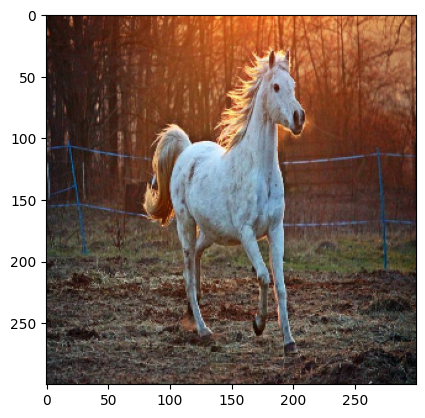

Human


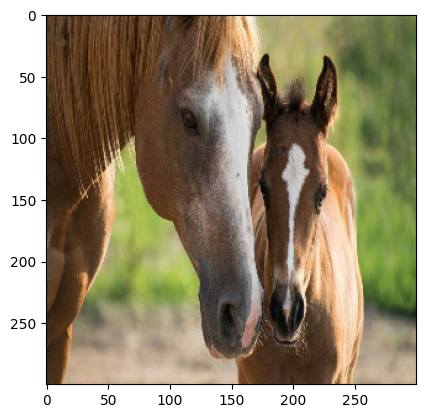

Horse


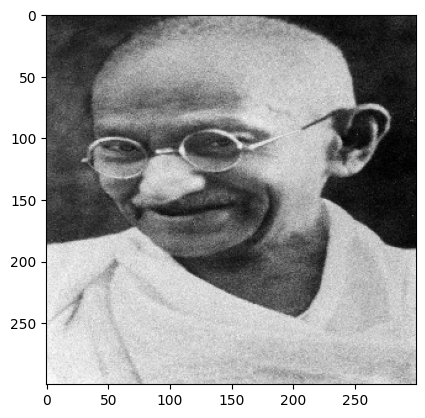

Human


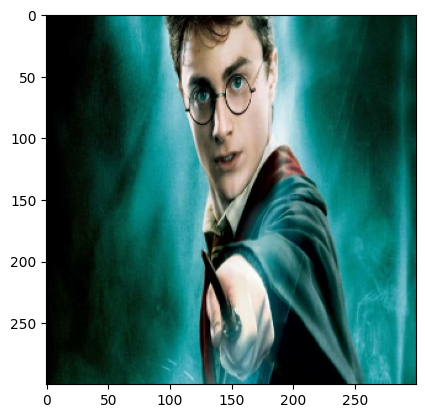

In [19]:
y_pred = hh_model.predict(test_ds_scaled) #new_hh_model.predict(test_ds_scaled)
print(y_pred)
y_pred_label = ["Horse" if el<0.5 else "Human" for el in y_pred ]

##### Test Set

for x in test_ds:
    print(x.shape,type(x))
    if(x.shape[0]<32):
        for i in range(0,x.shape[0]):
            print(y_pred_label[i])
            plt.imshow(x.numpy()[i].astype('uint8'))  #Float values
            plt.show()